In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import gensim
from gensim.models.doc2vec import TaggedDocument
from konlpy.tag import Komoran
import cv2
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from PIL import Image
import PIL
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as transforms
from nltk import pos_tag
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import keras
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, accuracy_score,roc_auc_score
from focal_loss import BinaryFocalLoss
from imblearn.over_sampling import ADASYN
from collections import Counter

In [5]:
data = pd.read_csv('./coco_valid.csv')

In [6]:
data

,file_name,caption,supercategory
0,000000397133.jpg,A man is in a kitchen making pizzas.,kitchen
1,000000037777.jpg,The dining table near the kitchen has a bowl o...,furniture
2,000000252219.jpg,a person with a shopping cart on a city street,person
3,000000087038.jpg,A person on a skateboard and bike at a skate p...,vehicle
4,000000174482.jpg,a blue bike parked on a side walk,vehicle
...,...,...,...
4995,000000512403.jpg,A vase of feathers on a shelf by some art.,indoor
4996,000000168974.jpg,A little baby sitting on the floor with a cell...,electronic
4997,000000552775.jpg,A man pokes his head in front of an oven open ...,kitchen
4998,000000394940.jpg,a kid eating a cake on table looking around,kitchen


In [36]:
data[['supercategory']].to_csv('./valid_label.csv',index=False)

# Text Vectorize

In [58]:
tagged_corpus_list_tr = []

for index, row in tqdm(data.iterrows(), total=len(data)):
    text = row['caption']
    tagged_corpus_list_tr.append(TaggedDocument(tags=['tweet_'+str(index)], words=pos_tag(word_tokenize(text))))

print('문서의 수 :', len(tagged_corpus_list_tr))

100%|█████████████████████████████████████████████████████████████████████████| 118287/118287 [02:14<00:00, 880.14it/s]

문서의 수 : 118287


In [59]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=250, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=3, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 1992, # for reproducibility
                                 ) 

In [60]:
model_d2v.build_vocab([i for i in tqdm(tagged_corpus_list_tr)])

model_d2v.train(tagged_corpus_list_tr, total_examples= len(df), epochs=100)

100%|█████████████████████████████████████████████████████████████████████| 118287/118287 [00:00<00:00, 4744084.73it/s]


In [61]:
docvec_arrays = np.zeros((len(data), 250)) 
for i in range(0,len(data)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,250))
doc_vectors = pd.DataFrame(docvec_arrays) 
doc_vectors.shape

C:\Users\user\AppData\Local\Temp/ipykernel_29056/2440334869.py:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,250))


(118287, 250)

In [62]:
doc_vectors.to_csv('text_vectors_train.csv')

# 이미지 벡터 뽑기

In [42]:
CFG = {
    'IMG_SIZE':256,
    'EPOCHS':30,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':256,
    'SEED':41
}
# 이미지 사이즈, 에폭, 학습률, 배치사이즈, 시드 고정

In [43]:
cnn_extract = timm.create_model('seresnext26d_32x4d', pretrained=True)
cnn_extract=nn.Sequential(*list(cnn_extract.children())[:-1],
                              nn.Linear(2048,1024),
                              nn.ReLU(),
                              nn.Linear(1024,250),
                              nn.ReLU())

In [44]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [49]:
data['file_name'] = './val2017/'+data['file_name']

In [51]:
imag_fetures=[]
img_path_list= data['file_name']
for ind in tqdm(range(0,len(data))):
    image = PIL.Image.open(data['file_name'][ind]).convert('RGB')
    img = transform(image)
    img = img.reshape(1,3,224,224)
    img_feature = cnn_extract(img)
    img_feature = img_feature[0].detach().numpy()
    imag_fetures.append(img_feature)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:30<00:00, 11.10it/s]


In [52]:
img_vec = pd.DataFrame(imag_fetures)
img_vec.to_csv('./img_vecs_val.csv')

# 벡터 합쳐서 Multi-Modal Learing하기

In [102]:
df = pd.DataFrame(Y)

df.reset_index(drop=True,inplace=True)

df.drop([5961],axis=0,inplace=True)

In [212]:
te = pd.read_csv('text_vectors.csv') # Doc2vec으로 뽑은 10차원의 Vector들
te.drop('Unnamed: 0',axis=1,inplace=True)

images = pd.read_csv('img_vecs.csv') # CNN으로 뽑은 10차원의 Vector들
images.drop('Unnamed: 0',axis=1,inplace=True)

Y = df.fraud

In [213]:
te['img=1']=0
images['img=1']=1

d_for_eda = pd.concat([te,images],axis=0)

In [214]:
x = d_for_eda.drop(['img=1'],axis=1)
y = d_for_eda['img=1']

x.reset_index(drop=True,inplace=True)

In [215]:
# PCA로 2차원으로 줄인 후, 시각화하는 함수 선언
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

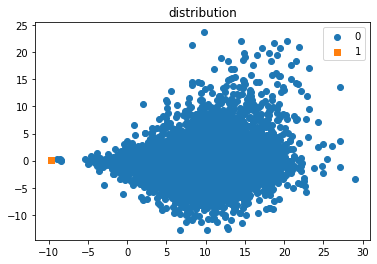

In [216]:
# Text Vecotr스케일링 전 분포
pca = PCA(n_components=2)
X = pca.fit_transform(x)
plot_2d_space(X, y, 'distribution')

In [217]:
te.drop(['img=1'],axis=1,inplace=True)

images.drop(['img=1'],axis=1,inplace=True)

scaler_ = MinMaxScaler()
te = scaler_.fit_transform(te)
te = pd.DataFrame(te)

In [218]:
images.columns=images.columns.astype(int)

In [219]:
te['img=1']=0
images['img=1']=1

In [247]:
data = pd.concat([te,images],axis=0)

data.reset_index(drop=True,inplace=True)

In [248]:
data

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,img=1
0,0.648852,0.523655,0.365940,0.479225,0.423836,0.421504,0.553305,0.502822,0.465589,0.403056,...,0.461471,0.456706,0.536948,0.430198,0.583423,0.465435,0.543142,0.292435,0.511274,0
1,0.695223,0.404704,0.481744,0.471253,0.546826,0.563840,0.415245,0.525191,0.242436,0.482916,...,0.365318,0.334757,0.791948,0.551664,0.509636,0.534890,0.801420,0.357618,0.369434,0
2,0.494821,0.589298,0.415277,0.189493,0.504714,0.399267,0.475658,0.613303,0.481338,0.361565,...,0.399088,0.375533,0.625254,0.706107,0.462215,0.647268,0.691951,0.354071,0.501289,0
3,0.669193,0.480175,0.323079,0.526918,0.464030,0.510608,0.464472,0.588336,0.495901,0.417870,...,0.416434,0.343408,0.601899,0.606687,0.556595,0.506560,0.568071,0.457447,0.457898,0
4,0.597028,0.522461,0.280566,0.225226,0.311107,0.601460,0.843626,0.541196,0.644902,0.391179,...,0.689361,0.845401,0.516431,0.515552,0.500947,0.774651,0.206694,0.488437,0.198927,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14673,0.052183,0.081453,0.051781,0.040973,0.000000,0.046116,0.062474,0.020894,0.000000,0.049345,...,0.018226,0.128377,0.000000,0.000000,0.000000,0.000000,0.034227,0.020655,0.014798,1
14674,0.056713,0.063406,0.051460,0.050890,0.000000,0.023285,0.063601,0.051094,0.000000,0.071489,...,0.022994,0.131115,0.000000,0.000000,0.000000,0.000000,0.011076,0.000000,0.017682,1
14675,0.098683,0.062934,0.041942,0.084649,0.000000,0.057569,0.031315,0.051589,0.000000,0.059239,...,0.003142,0.073598,0.004982,0.000000,0.000000,0.000000,0.035690,0.000000,0.040590,1
14676,0.104365,0.041902,0.063815,0.025020,0.000000,0.026625,0.023413,0.025496,0.000000,0.074658,...,0.022484,0.107304,0.000000,0.000000,0.000000,0.000000,0.025891,0.003477,0.047743,1


In [28]:
x = data.drop(['img=1'],axis=1)
y = data['img=1']

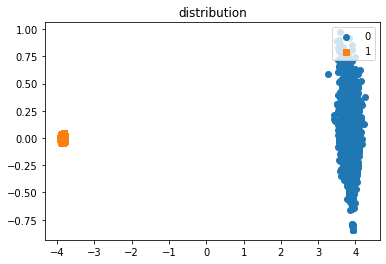

In [29]:
x.reset_index(drop=True,inplace=True)
# Text Vector스케일링 후 분포
pca = PCA(n_components=2)
X = pca.fit_transform(x)
plot_2d_space(X, y, 'distribution')

# 가중치 학습 전 성능 체크-단순 concat

In [30]:
check = data.drop(['img=1'],axis=1)

In [31]:
T = check.iloc[:7339 :]
I = check.iloc[7339:,:]

In [32]:
I.columns = I.columns.astype(int)
T.columns = T.columns.astype(int)

In [33]:
I.reset_index(drop=True,inplace=True)
check_P = pd.concat([T,I],axis=1)

In [34]:
check_P

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.648852,0.523655,0.365940,0.479225,0.423836,0.421504,0.553305,0.502822,0.465589,0.403056,...,0.158127,0.019765,0.100562,0.000000,0.0,0.0,0.0,0.001821,0.000000,0.006921
1,0.695223,0.404704,0.481744,0.471253,0.546826,0.563840,0.415245,0.525191,0.242436,0.482916,...,0.121185,0.000000,0.106873,0.000000,0.0,0.0,0.0,0.034849,0.017653,0.059295
2,0.494821,0.589298,0.415277,0.189493,0.504714,0.399267,0.475658,0.613303,0.481338,0.361565,...,0.089260,0.001131,0.092235,0.020138,0.0,0.0,0.0,0.000000,0.000000,0.016745
3,0.669193,0.480175,0.323079,0.526918,0.464030,0.510608,0.464472,0.588336,0.495901,0.417870,...,0.093659,0.001686,0.091394,0.006416,0.0,0.0,0.0,0.045590,0.014915,0.016886
4,0.597028,0.522461,0.280566,0.225226,0.311107,0.601460,0.843626,0.541196,0.644902,0.391179,...,0.133225,0.006217,0.074262,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,0.676378,0.666122,0.417789,0.515727,0.437921,0.543716,0.506942,0.598817,0.480514,0.505614,...,0.144151,0.018226,0.128377,0.000000,0.0,0.0,0.0,0.034227,0.020655,0.014798
7335,0.561173,0.634774,0.336364,0.685416,0.253067,0.354954,0.568977,0.610128,0.289833,0.360720,...,0.141824,0.022994,0.131115,0.000000,0.0,0.0,0.0,0.011076,0.000000,0.017682
7336,0.666560,0.471321,0.431195,0.495907,0.462048,0.470431,0.587374,0.671612,0.520112,0.529321,...,0.130567,0.003142,0.073598,0.004982,0.0,0.0,0.0,0.035690,0.000000,0.040590
7337,0.539683,0.522105,0.333588,0.516626,0.512307,0.466735,0.493935,0.583369,0.525506,0.498944,...,0.102406,0.022484,0.107304,0.000000,0.0,0.0,0.0,0.025891,0.003477,0.047743


In [35]:
check_P.columns=range(0,500)

x_train,x_test,y_train,y_test = train_test_split(check_P,Y,shuffle=True, test_size=0.25,random_state=123)

In [36]:
# 오버샘플링(ADASYN) 적용하기
X_ada, y_ada = ADASYN(random_state=1992).fit_resample(x_train, y_train)
print("normal data distribution: {}".format(Counter(y_train)))
print("Adasyn data distribution: {}".format(Counter(y_ada)))

normal data distribution: Counter({0: 5440, 1: 64})
Adasyn data distribution: Counter({1: 5446, 0: 5440})


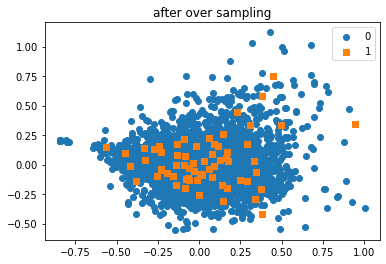

In [37]:
# 오버샘플링 후 데이터 분포
pca = PCA(n_components=2)
X = pca.fit_transform(x_train)
plot_2d_space(X, y_train, 'after over sampling')

In [43]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=500, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일
    loss = keras.losses.BinaryCrossentropy()
    model.compile(loss=loss,
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(X_ada, y_ada, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test)[1]))

Epoch 1/50
341/341 [==============================] - 2s 4ms/step - loss: 0.6135 - accuracy: 0.6262
Epoch 2/50
341/341 [==============================] - 1s 4ms/step - loss: 0.3430 - accuracy: 0.8526
Epoch 3/50
341/341 [==============================] - 1s 4ms/step - loss: 0.2122 - accuracy: 0.9170
Epoch 4/50
341/341 [==============================] - 1s 4ms/step - loss: 0.1617 - accuracy: 0.9394
Epoch 5/50
341/341 [==============================] - 1s 4ms/step - loss: 0.2143 - accuracy: 0.9159
Epoch 6/50
341/341 [==============================] - 1s 4ms/step - loss: 0.2149 - accuracy: 0.9279
Epoch 7/50
341/341 [==============================] - 1s 4ms/step - loss: 0.1166 - accuracy: 0.9611
Epoch 8/50
341/341 [==============================] - 1s 4ms/step - loss: 0.2057 - accuracy: 0.9278
Epoch 9/50
341/341 [==============================] - 1s 4ms/step - loss: 0.1606 - accuracy: 0.9439
Epoch 10/50
341/341 [==============================] - 1s 4ms/step - loss: 0.2116 - accuracy: 0.9315

In [44]:
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    
    predic =[]
    for i in range(len(pred)):
        if pred[i]<0.5:
            predic.append(0)
        else:
            predic.append(1)

In [45]:
print(recall_score(y_test, predic))
print(accuracy_score(y_test,predic)) 
print(f1_score(y_test,predic))       
print(roc_auc_score(y_test,predic))
print(precision_score(y_test,predic))

0.15789473684210525
0.9705722070844687
0.09999999999999999
0.5684848133549734
0.07317073170731707


# 초평면까지 거리비율 계산

In [249]:
for indice in tqdm(range(1,17)):
    text['img=1']=0
    img['img=1']=1
    data = pd.concat([text,img],axis=0)
    
    x = data.drop('img=1',axis=1)
    y= data['img=1']
    
    model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    clf = model.fit(x, y)
    dis = clf.decision_function(x)
    
    dis = pd.DataFrame(dis,columns=['to_hp'])
    
    x.reset_index(drop=True,inplace=True)
    
    new = pd.concat([x,dis],axis=1)
    
    new['to_hp'].iloc[:7339] = new['to_hp'].iloc[:7339]*-1
    
    new['weight']=0
    wei=[]
    for i in tqdm(range(0,7339)):
        we = new['to_hp'][i] / (new['to_hp'][i]+new['to_hp'][7339+i])
        wei.append(we)
    
    wei2=[]
    for i in tqdm(range(7339,len(new))):
        we = new['to_hp'][i] / (new['to_hp'][i]+new['to_hp'][i-7339])
        wei2.append(we)
    
    new['weight'] = wei+wei2
    
    new.drop(['to_hp'],axis=1,inplace=True)
    
    text = new.iloc[:7339,:]
    img = new.iloc[7339:,:]
    img.reset_index(drop=True,inplace=True)
    
    for i in tqdm(range(0,7339)):
        text.iloc[i:i+1,:250] = text.iloc[i:i+1,:250]*(text['weight'][i])
        img.iloc[i:i+1,:250] = img.iloc[i:i+1,:250]*(img['weight'][i])
        
    text.drop(['weight'],axis=1,inplace=True)
    img.drop(['weight'],axis=1,inplace=True)
    
    #text.drop(['img=1'],axis=1,inplace=True)
    #img.drop(['img=1'],axis=1,inplace=True)
    
    con = text+img
    scaler_ = MinMaxScaler()
    con = scaler_.fit_transform(con)
    con = pd.DataFrame(con)
    
    Y.reset_index(drop=True,inplace=True)

    Datum = pd.concat([con,Y],axis=1)
    
    X = Datum.drop('fraud',axis=1)
    Y = Datum.fraud

    X.columns = range(0,250)

    x_train,x_test,y_train,y_test = train_test_split(X,Y,shuffle=True, test_size=0.25,random_state=123,stratify=Y)
    # 오버샘플링(ADASYN) 적용하기
    X_ada, y_ada = ADASYN(random_state=1992).fit_resample(x_train, y_train)
    print("normal data distribution: {}".format(Counter(y_train)))
    print("Adasyn data distribution: {}".format(Counter(y_ada)))
    
    X_ada = np.array(X_ada).astype(float)
    x_test = np.array(x_test).astype(float)
    y_ada = np.array(y_ada).astype(float)
    y_test = np.array(y_test).astype(float)

    with tf.device("/device:CPU:0"):
        # 모델의 설정
        model = Sequential()
        model.add(Dense(512,  input_dim=250, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        # 모델 컴파일
        loss = keras.losses.BinaryCrossentropy()
        model.compile(loss=loss,
                    optimizer='adam',
                    metrics=['accuracy'])
        
        # 모델 실행
        model.fit(X_ada, y_ada, epochs=50, batch_size=32,verbose=0)
        
        # 결과 출력
        pred = model.predict(x_test)

        predic =[]
        for i in range(len(pred)):
            if pred[i]<0.5:
                predic.append(0)
            else:
                predic.append(1)
        print('-'*10)
        print(indice)
        print("\n recall_score: %.4f" %recall_score(y_test, predic))
        print("\n accuracy_score: %.4f" %accuracy_score(y_test,predic)) 
        print("\n f1_score: %.4f" %f1_score(y_test,predic))       
        print("\n roc_auc_score: %.4f" %roc_auc_score(y_test,predic))
        print("\n precision_score: %.4f" %precision_score(y_test,predic))
        print('-'*10)

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 98083.07it/s]

100%|███████████

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({0: 5442, 1: 5439})


  6%|█████▏                                                                             | 1/16 [00:54<13:37, 54.48s/it]

----------
1

 recall_score: 0.0476

 accuracy_score: 0.9820

 f1_score: 0.0571

 roc_auc_score: 0.5202

 precision_score: 0.0714
----------


C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 96789.91it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 96792.95it/s]

  0%|         

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({0: 5442, 1: 5439})


 12%|██████████▍                                                                        | 2/16 [01:49<12:48, 54.88s/it]

----------
2

 recall_score: 0.2381

 accuracy_score: 0.9379

 f1_score: 0.0806

 roc_auc_score: 0.5920

 precision_score: 0.0485
----------


C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 96793.86it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 98083.38it/s]

  0%|         

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({0: 5442, 1: 5439})


 19%|███████████████▌                                                                   | 3/16 [02:43<11:49, 54.57s/it]

----------
3

 recall_score: 0.1905

 accuracy_score: 0.9619

 f1_score: 0.1026

 roc_auc_score: 0.5806

 precision_score: 0.0702
----------


C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 98116.83it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 99404.19it/s]

  0%|         

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({0: 5442, 1: 5439})


 25%|████████████████████▊                                                              | 4/16 [03:38<10:54, 54.57s/it]C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1


----------
4

 recall_score: 0.2381

 accuracy_score: 0.9226

 f1_score: 0.0658

 roc_auc_score: 0.5843

 precision_score: 0.0382
----------



100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 96824.92it/s]

100%|██████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 100768.64it/s]

  0%|                                                                                         | 0/7339 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({0: 5442, 1: 5439})


 31%|█████████████████████████▉                                                         | 5/16 [04:34<10:06, 55.15s/it]C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1


----------
5

 recall_score: 0.2381

 accuracy_score: 0.8883

 f1_score: 0.0465

 roc_auc_score: 0.5670

 precision_score: 0.0258
----------



100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 95535.44it/s]

100%|██████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 102203.63it/s]

  0%|                                                                                         | 0/7339 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({0: 5442, 1: 5439})


 38%|███████████████████████████████▏                                                   | 6/16 [05:28<09:07, 54.73s/it]C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1


----------
6

 recall_score: 1.0000

 accuracy_score: 0.0371

 f1_score: 0.0232

 roc_auc_score: 0.5130

 precision_score: 0.0117
----------



100%|██████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 100769.63it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 99404.51it/s]

  0%|                                                                                         | 0/7339 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({0: 5442, 1: 5439})


 44%|████████████████████████████████████▎                                              | 7/16 [06:21<08:07, 54.19s/it]

----------
7

 recall_score: 0.3333

 accuracy_score: 0.8545

 f1_score: 0.0498

 roc_auc_score: 0.5969

 precision_score: 0.0269
----------


C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 96791.12it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 98116.52it/s]

  0%|         

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({0: 5442, 1: 5439})


 50%|█████████████████████████████████████████▌                                         | 8/16 [07:20<07:26, 55.76s/it]C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1


----------
8

 recall_score: 0.2381

 accuracy_score: 0.9095

 f1_score: 0.0568

 roc_auc_score: 0.5777

 precision_score: 0.0323
----------



100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 95536.33it/s]

100%|██████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 100765.01it/s]

  0%|                                                                                         | 0/7339 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({0: 5442, 1: 5420})


 56%|██████████████████████████████████████████████▋                                    | 9/16 [08:18<06:34, 56.37s/it]

----------
9

 recall_score: 0.2381

 accuracy_score: 0.9439

 f1_score: 0.0885

 roc_auc_score: 0.5951

 precision_score: 0.0543
----------


C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 96790.21it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 99405.79it/s]

  0%|         

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({1: 5453, 0: 5442})


 62%|███████████████████████████████████████████████████▎                              | 10/16 [09:13<05:36, 56.04s/it]

----------
10

 recall_score: 0.9524

 accuracy_score: 0.1956

 f1_score: 0.0264

 roc_auc_score: 0.5696

 precision_score: 0.0134
----------


C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 99441.11it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 99442.72it/s]

  0%|         

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({1: 5453, 0: 5442})


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [10:11<04:42, 56.51s/it]

----------
11

 recall_score: 0.2381

 accuracy_score: 0.9373

 f1_score: 0.0800

 roc_auc_score: 0.5918

 precision_score: 0.0481
----------


C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 95562.13it/s]

100%|██████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 100802.63it/s]

  0%|         

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({1: 5453, 0: 5442})


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [11:09<03:47, 56.97s/it]

----------
12

 recall_score: 0.3333

 accuracy_score: 0.8283

 f1_score: 0.0426

 roc_auc_score: 0.5837

 precision_score: 0.0227
----------


C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 96793.25it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 99407.72it/s]

  0%|         

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({1: 5453, 0: 5442})


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [12:05<02:49, 56.59s/it]C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1


----------
13

 recall_score: 0.8571

 accuracy_score: 0.4016

 f1_score: 0.0317

 roc_auc_score: 0.6268

 precision_score: 0.0162
----------



100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 99441.44it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 99396.80it/s]

  0%|                                                                                         | 0/7339 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({1: 5453, 0: 5442})


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [13:03<01:54, 57.09s/it]

----------
14

 recall_score: 0.2381

 accuracy_score: 0.9068

 f1_score: 0.0552

 roc_auc_score: 0.5763

 precision_score: 0.0312
----------


C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/1389489037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1

100%|██████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 100804.28it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 99440.79it/s]

  0%|         

normal data distribution: Counter({0: 5442, 1: 62})
Adasyn data distribution: Counter({1: 5453, 0: 5442})


KeyboardInterrupt: 

In [222]:
x = data.drop('img=1',axis=1)
y= data['img=1']

model = svm.SVC(kernel='poly',decision_function_shape='ovo')
clf = model.fit(x, y)
dis = clf.decision_function(x)

dis = pd.DataFrame(dis,columns=['to_hp'])

In [223]:
x.reset_index(drop=True,inplace=True)

new = pd.concat([x,dis],axis=1)

In [224]:
new

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,to_hp
0,0.648852,0.523655,0.365940,0.479225,0.423836,0.421504,0.553305,0.502822,0.465589,0.403056,...,0.461471,0.456706,0.536948,0.430198,0.583423,0.465435,0.543142,0.292435,0.511274,-1.210389
1,0.695223,0.404704,0.481744,0.471253,0.546826,0.563840,0.415245,0.525191,0.242436,0.482916,...,0.365318,0.334757,0.791948,0.551664,0.509636,0.534890,0.801420,0.357618,0.369434,-1.272626
2,0.494821,0.589298,0.415277,0.189493,0.504714,0.399267,0.475658,0.613303,0.481338,0.361565,...,0.399088,0.375533,0.625254,0.706107,0.462215,0.647268,0.691951,0.354071,0.501289,-1.198306
3,0.669193,0.480175,0.323079,0.526918,0.464030,0.510608,0.464472,0.588336,0.495901,0.417870,...,0.416434,0.343408,0.601899,0.606687,0.556595,0.506560,0.568071,0.457447,0.457898,-1.254723
4,0.597028,0.522461,0.280566,0.225226,0.311107,0.601460,0.843626,0.541196,0.644902,0.391179,...,0.689361,0.845401,0.516431,0.515552,0.500947,0.774651,0.206694,0.488437,0.198927,-1.518390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14673,0.052183,0.081453,0.051781,0.040973,0.000000,0.046116,0.062474,0.020894,0.000000,0.049345,...,0.018226,0.128377,0.000000,0.000000,0.000000,0.000000,0.034227,0.020655,0.014798,0.999730
14674,0.056713,0.063406,0.051460,0.050890,0.000000,0.023285,0.063601,0.051094,0.000000,0.071489,...,0.022994,0.131115,0.000000,0.000000,0.000000,0.000000,0.011076,0.000000,0.017682,0.999755
14675,0.098683,0.062934,0.041942,0.084649,0.000000,0.057569,0.031315,0.051589,0.000000,0.059239,...,0.003142,0.073598,0.004982,0.000000,0.000000,0.000000,0.035690,0.000000,0.040590,0.999768
14676,0.104365,0.041902,0.063815,0.025020,0.000000,0.026625,0.023413,0.025496,0.000000,0.074658,...,0.022484,0.107304,0.000000,0.000000,0.000000,0.000000,0.025891,0.003477,0.047743,0.999832


In [225]:
new['to_hp'].iloc[:7339] = new['to_hp'].iloc[:7339]*-1

In [226]:
new['weight']=0
wei=[]
for i in tqdm(range(0,7339)):
    we = new['to_hp'][i] / (new['to_hp'][i]+new['to_hp'][7339+i])
    wei.append(we)

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 96824.31it/s]


In [227]:
wei2=[]
for i in tqdm(range(7339,len(new))):
    we = new['to_hp'][i] / (new['to_hp'][i]+new['to_hp'][i-7339])
    wei2.append(we)

100%|███████████████████████████████████████████████████████████████████████████| 7339/7339 [00:00<00:00, 95521.80it/s]


In [228]:
new['weight'] = wei+wei2

new.drop(['to_hp'],axis=1,inplace=True)

In [229]:
new

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,weight
0,0.648852,0.523655,0.365940,0.479225,0.423836,0.421504,0.553305,0.502822,0.465589,0.403056,...,0.461471,0.456706,0.536948,0.430198,0.583423,0.465435,0.543142,0.292435,0.511274,0.547645
1,0.695223,0.404704,0.481744,0.471253,0.546826,0.563840,0.415245,0.525191,0.242436,0.482916,...,0.365318,0.334757,0.791948,0.551664,0.509636,0.534890,0.801420,0.357618,0.369434,0.560025
2,0.494821,0.589298,0.415277,0.189493,0.504714,0.399267,0.475658,0.613303,0.481338,0.361565,...,0.399088,0.375533,0.625254,0.706107,0.462215,0.647268,0.691951,0.354071,0.501289,0.545145
3,0.669193,0.480175,0.323079,0.526918,0.464030,0.510608,0.464472,0.588336,0.495901,0.417870,...,0.416434,0.343408,0.601899,0.606687,0.556595,0.506560,0.568071,0.457447,0.457898,0.556533
4,0.597028,0.522461,0.280566,0.225226,0.311107,0.601460,0.843626,0.541196,0.644902,0.391179,...,0.689361,0.845401,0.516431,0.515552,0.500947,0.774651,0.206694,0.488437,0.198927,0.602971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14673,0.052183,0.081453,0.051781,0.040973,0.000000,0.046116,0.062474,0.020894,0.000000,0.049345,...,0.018226,0.128377,0.000000,0.000000,0.000000,0.000000,0.034227,0.020655,0.014798,0.431442
14674,0.056713,0.063406,0.051460,0.050890,0.000000,0.023285,0.063601,0.051094,0.000000,0.071489,...,0.022994,0.131115,0.000000,0.000000,0.000000,0.000000,0.011076,0.000000,0.017682,0.458114
14675,0.098683,0.062934,0.041942,0.084649,0.000000,0.057569,0.031315,0.051589,0.000000,0.059239,...,0.003142,0.073598,0.004982,0.000000,0.000000,0.000000,0.035690,0.000000,0.040590,0.430347
14676,0.104365,0.041902,0.063815,0.025020,0.000000,0.026625,0.023413,0.025496,0.000000,0.074658,...,0.022484,0.107304,0.000000,0.000000,0.000000,0.000000,0.025891,0.003477,0.047743,0.452706


In [230]:
text = new.iloc[:7339,:]
img = new.iloc[7339:,:]
img.reset_index(drop=True,inplace=True)

In [231]:
for i in tqdm(range(0,7339)):
    text.iloc[i:i+1,:250] = text.iloc[i:i+1,:250]*(text['weight'][i])
    img.iloc[i:i+1,:250] = img.iloc[i:i+1,:250]*(img['weight'][i])

  0%|                                                                                         | 0/7339 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
100%|████████████████████████████████████████████████████████████████████████████| 7339/7339 [00:04<00:00, 1549.84it/s]


In [232]:
text.drop(['weight'],axis=1,inplace=True)
img.drop(['weight'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [233]:
text['img=1']=0
img['img=1']=1

C:\Users\user\AppData\Local\Temp/ipykernel_23600/560872207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_23600/560872207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img['img=1']=1


In [234]:
con = pd.concat([text,img],axis=0)
x = con.drop(['img=1'],axis=1)
y = con['img=1']

x.reset_index(drop=True,inplace=True)

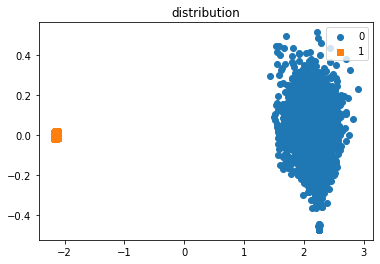

In [235]:
# 가중치 적용 후 분포
pca = PCA(n_components=2)
X = pca.fit_transform(x)
plot_2d_space(X, y, 'distribution')

# 가중치 적용해서 학습

In [644]:
text.drop(['img=1'],axis=1,inplace=True)
img.drop(['img=1'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [646]:
con = text+img

# Adasyn적용

In [647]:
Datum = pd.concat([con,Y],axis=1)

In [648]:
X = Datum.drop('fraud',axis=1)
Y = Datum.fraud

In [650]:
X.columns = range(0,250)

In [651]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,shuffle=True, test_size=0.25,random_state=123)

In [652]:
# 오버샘플링(ADASYN) 적용하기
X_ada, y_ada = ADASYN(random_state=1992).fit_resample(x_train, y_train)
print("normal data distribution: {}".format(Counter(y_train)))
print("Adasyn data distribution: {}".format(Counter(y_ada)))

normal data distribution: Counter({0: 5440, 1: 64})
Adasyn data distribution: Counter({0: 5440, 1: 5420})


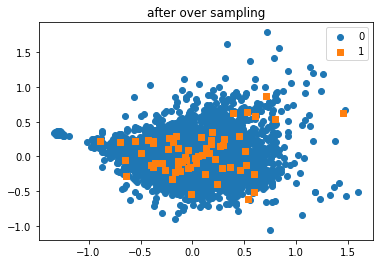

In [653]:
# 오버샘플링 후 데이터 분포
pca = PCA(n_components=2)
X = pca.fit_transform(x_train)
plot_2d_space(X, y_train, 'after over sampling')

In [655]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=250, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일
    loss = keras.losses.BinaryCrossentropy()
    model.compile(loss=loss,
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(X_ada, y_ada, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test)[1]))

Epoch 1/50
340/340 [==============================] - 1s 3ms/step - loss: 0.5791 - accuracy: 0.6798
Epoch 2/50
340/340 [==============================] - 1s 3ms/step - loss: 0.4219 - accuracy: 0.8064
Epoch 3/50
340/340 [==============================] - 1s 3ms/step - loss: 0.3562 - accuracy: 0.8379
Epoch 4/50
340/340 [==============================] - 1s 3ms/step - loss: 0.2998 - accuracy: 0.8733
Epoch 5/50
340/340 [==============================] - 1s 3ms/step - loss: 0.2763 - accuracy: 0.8886
Epoch 6/50
340/340 [==============================] - 1s 3ms/step - loss: 0.3372 - accuracy: 0.8627
Epoch 7/50
340/340 [==============================] - 1s 3ms/step - loss: 0.3115 - accuracy: 0.8781
Epoch 8/50
340/340 [==============================] - 1s 3ms/step - loss: 0.2913 - accuracy: 0.8799
Epoch 9/50
340/340 [==============================] - 1s 3ms/step - loss: 0.2899 - accuracy: 0.8867
Epoch 10/50
340/340 [==============================] - 1s 3ms/step - loss: 0.2771 - accuracy: 0.8976

In [656]:
pred = model.predict(x_test)

predic =[]
for i in range(len(pred)):
    if pred[i]<0.5:
        predic.append(0)
    else:
        predic.append(1)

In [657]:
print(recall_score(y_test, predic))
print(accuracy_score(y_test,predic)) 
print(f1_score(y_test,predic))       
print(roc_auc_score(y_test,predic))
print(precision_score(y_test,predic))

0.47368421052631576
0.873024523160763
0.07171314741035857
0.6754434268490609
0.03879310344827586
